In [161]:
# %%writefile eval_flow_former.py
import sys

from attr import validate
sys.path.append('core')

from PIL import Image
from pathlib import Path
import argparse
import os
import time
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from configs.submission import get_cfg as get_submission_cfg
from configs.things_eval import get_cfg as get_things_cfg
from configs.small_things_eval import get_cfg as get_small_things_cfg
from core.utils.misc import process_cfg
import datasets
from utils import flow_viz
from utils import frame_utils
from tqdm import tqdm_notebook as tqdm

import cv2

import flow_viz
import skvideo.io

from core.FlowFormer import build_flowformer
from raft import RAFT

from utils.utils import InputPadder, forward_interpolate
import imageio
import itertools

dcn = lambda x: x.detach().cpu().numpy()

TRAIN_SIZE = [432, 960]

def format_img(img):
    img = np.array(img).astype(np.uint8)[..., :3]
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None]

def read_frames(folder_path, glob='*.jpg'):
    frames_pathes = list(Path(folder_path).glob(glob))
    frames_pathes.sort(key=lambda x: int(x.stem))
    frames = [cv2.cvtColor(cv2.imread(str(frame_path)), cv2.COLOR_BGR2RGB) for frame_path in frames_pathes]
    return frames

class OpticalFlowFormer(torch.nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()
        self.device = device
        cfg = get_things_cfg()

        self.model = torch.nn.DataParallel(build_flowformer(cfg))
        self.model.load_state_dict(torch.load('things.pth'))
        self.model = self.model.eval().to(self.device)

    def forward(self, frames):
        with torch.no_grad():
            flows = []
            for img1_path, img2_path in zip(frames[:-1], frames[1:]):
                image1 = format_img(img1_path).to(self.device)
                image2 = format_img(img2_path).to(self.device)
                padder = InputPadder(image1.shape)
                image1, image2 = padder.pad(image1, image2)

                flow = self.model(image1, image2)
                flow_unpad = padder.unpad(flow[0]).cpu()[0]
                flows.append(flow_unpad)
        return flows

opt_flow = OpticalFlowFormer()

frames = read_frames(str(Path('../planarrecon/DAVIS/JPEGImages/480p/bear')))

print('frames', frames[0].max())

flows = opt_flow(frames)

print('flows', flows[0].max())

Overwriting eval_flow_former.py


In [160]:
!python eval_flow_former.py

frames 255
eval_flow_former.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img1_path, img2_path in tqdm(zip(frames[:-1], frames[1:])):
0it [00:00, ?it/s]
/home/ishpuntov/miniconda3/envs/flowformer/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
flows tensor(3.1245)


In [121]:
frame_pathes = list(map(str, frame_pathes))
with torch.no_grad():
    model.eval()
    flows = []
    for img1_path, img2_path in tqdm(zip(frame_pathes[:-1], frame_pathes[1:])):
        image1 = get_img(img1_path)[None].cuda()
        image2 = get_img(img2_path)[None].cuda()
        padder = InputPadder(image1.shape)
        image1, image2 = padder.pad(image1, image2)

        flow_pre = model(image1, image2)
        flow_pre = padder.unpad(flow_pre[0]).cpu()[0]
        flows.append(flow_pre)

/home/ishpuntov/miniconda3/envs/flowformer/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


0it [00:00, ?it/s]

In [16]:
frame_pathes = list(Path('../planarrecon/DAVIS/JPEGImages/480p/bear').glob('*.jpg'))

In [115]:
frames = read_frames('../planarrecon/DAVIS/JPEGImages/480p/bear')

In [118]:
!rm -rf ../planarrecon/DAVIS/JPEGImages/480p/bear_flow/

In [127]:
raft_flows = list(map(np.load, Path('../planarrecon/DAVIS/JPEGImages/480p/bear_flow/').glob('*')))

In [ ]:
frames = read_frames('../planarrecon/DAVIS/JPEGImages/480p/bear_flow/')

In [117]:
skvideo.io.vwrite('bear_vid.mp4', frames)

In [101]:
def draw_flow(img, field, step=50):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = field[y, x].T * 10
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = img.copy()
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 2, (0, 255,0), -1)
    return vis

In [131]:
raft_flos = []
for flow, frame_path in zip(raft_flows, frame_pathes):
    img = np.array(Image.open(frame_path))
    flo_img = draw_flow(img, flow)
    raft_flos.append(flo_img)

In [102]:
flos = []
for flow, frame_path in zip(flows, frame_pathes):
    img = np.array(Image.open(frame_path))
    flo = dcn(flow.permute([1,2,0]))
    flo_img = draw_flow(img, flo)
    flos.append(flo_img)

In [136]:
sbs_flows = []
for fl1,fl2 in zip(raft_flos, flos):
    sbs_flows.append(np.hstack([fl1,fl2]))

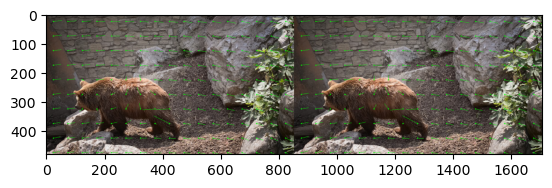

In [138]:
video_name = 'sbs_flows.mp4'
skvideo.io.vwrite(video_name, sbs_flows)
plt.imshow(sbs_flows[1])